In [5]:
!jt -t oceans16 -T
## chnaging the Theme of the Jupyter notebook

Error processing line 1 of /opt/anaconda3/lib/python3.7/site-packages/vision-1.0.0-py3.7-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/anaconda3/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 580, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


## *Brief introduction to Heston and some properties*
The EMH(Efficient Market Hypothesis) is a conjecture in financial economics, which simply suggests the market is efficent; in other words the price of every asset at the current moment reflects all available information out there(even inside trading). Of course at first glance this seems almost blatantly incorrect and useless, but there are much larger implications if we build on this assumption. So recall that the idea behind an efficent market is that the market immediately reacts to new information about an asset, for example Elon Musk tweets something. The implication of this is that if arbitrage opportunities exist, then the market will soon get rid of them and therefore it is impossible to beat the market i.e no arbitrage opportunities exist. Clearly, the EMH line of thinking works perfectly in conjuction with no arbitrage pricing theory. Also, notably in 1965, Paul Samuelson published a proof showing if the market is efficient,then prices will display random-walk behavior. And of course it is well known that the no arbitrage pricing model developed by Fisher Black, Myron Scholes, and Robert Merton asssumes a weak form of the EMH. The Black-Scholes closed form solution for a European call or put option revolutionized the finance industry, but many were wary of Black-Scholes seeking a more sophisticated algorthim which takes into account more complicated assumptions such as changing interest rates, changing volatility, thicker tail ditributions etc. 
The main reasons why Black-Scholes model fails to match reality due to the assumptions of constant volatility and of lognormal distribution of returns. In reality volatility is a dynamic quantity and the lognormal distribution is not leptokurtic enough(fatter tails on distribution). In this notebook we will price a European call options on SPX using the Heston model, which proposes that the stock price undergoes the same continuous geometric Brownian motion as in Black-Scholes, but with a stochastic mean-reverting square root variance(Cox-Ingresoll-Ross process typically used for interest rates).  The strategic advantage of this square root in the variance is to preclude the possibility of negative variances. The Wiener processes of the stock price and variance are correlated with correlation rho. The calibration of the model is done through either MSE, maximizing the log likelihood or through Monte Carlo.  

\begin{array}{rcl} dS(t, S) &=& \mu S dt + \sqrt{v} S dW_1 \\ dv(t, S) &=& \kappa (\theta - v) dt + \sigma 
\sqrt{v} dW_2 \\ dW_1 dW_2 &=& \rho dt \end{array} 

As kappa approaches infinity the process remains asympototically stable as the equilibrium of theta remains the same. In this example we only consider mean reverting terms on the variance SDE. The mean-reverting term in the SDE of the volatility is used to exhibit the well known tendency of volatility models in time-series to cluster and display autocorrelation. Clearly as we increase kappa once the volatility is greater than the mean than the whole drift term increases. Vice versa when volatility goes below the mean. 


In [45]:
 %%latex
The Heston process can be rewritten as a system of coupled SDE 
\begin{align}
\\\begin{pmatrix}
dS_t \\
dv_t
\end{pmatrix}
&=&

\begin{pmatrix}
 \mu S_t \\
 \kappa(\theta-v(t))
\end{pmatrix}dt +

\begin{pmatrix} 
 \sqrt{v(t)} S_t & 0 \\
0 &  \sigma \sqrt{v(t)}
\end{pmatrix}

\begin{pmatrix}
dW_1 \\
dW_2
\end{pmatrix}
 \end{align}

where the Wiener processes of S_t and v_t can be rewritten as independent Brownian motions using Cholskey decomposition


\begin{align}
 \\ \begin{pmatrix}
dS_t \\
dv_t
\end{pmatrix}
&=&

\begin{pmatrix}
 \mu S_t \\
 \kappa(\theta-v(t))
\end{pmatrix}dt +

\begin{pmatrix} 
 chol(1,1) \sqrt{v(t)} S_t & chol(1,2) \sqrt{v(t)} S_t \\
0 & chol(2,2) \sigma \sqrt{v(t)}
\end{pmatrix}

\begin{pmatrix}
dW_1 \\
dW_2
\end{pmatrix}

\end{align}
where the coefficents of the decomposition are given in terms of the correlation 


\begin{align}
 \\ \begin{pmatrix}
dS_t \\
dv_t
\end{pmatrix}
&=&

\begin{pmatrix}
 \mu S_t \\
 \kappa(\theta-v(t))
\end{pmatrix}dt +

\begin{pmatrix} 
 chol(1,1) \sqrt{v(t)} S_t & chol(1,2) \sqrt{v(t)} S_t \\
0 & chol(2,2) \sigma \sqrt{v(t)}
\end{pmatrix}

\begin{pmatrix}
dW_1 \\
dW_2
\end{pmatrix}

\end{align}

<IPython.core.display.Latex object>

where chol(i,j) are the ith jth element of the Cholskey decomposition of the covariance martix of the processes. For a given time t > 0 the variance follows a noncentral chi-squared distribution

\begin{array}{rcl} v(t)\sim c\chi^2(d,\lambda)  \end{array} 
where
\begin{array}{rcl} c= \frac{1}{4\kappa}\sigma^2(1-\exp(-\kappa t),\\ d=\frac{4\kappa \theta}{\sigma^2},\\ \lambda=\frac{4 \kappa v_0 \exp(- \kappa t)}{\sigma^2(1-\exp(-\kappa t)}  \end{array}



The Feller condition states that \begin{array}{rcl} \frac{2\kappa \theta}{\sigma^2} <1 \end{array} it is often used as a condition to check if the variance is negative; however mathematically it has been demonstrated if true there exists a unique positive solution for the variance on a finite time interval, Llya Gikhman proved this theroem in 2011; however the Feller condition is often violated when used in practice so it is common to ignore this metric.

link to Gikhman's paper:https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1756450&download=yes




Cholskey Decomposition:https://www.youtube.com/watch?v=7f0rCxmzXy8 


variance chi-squared distribution:https://www.youtube.com/watch?v=MJw1tg43uJE&t=2840s 

Now let us try and simulate these processes, so recall that the Stochastic process is given by 
\begin{array}{rcl} dS(t, S) &=& \mu S dt + \sqrt{v} S dW_1 \\ dv(t, S) &=& \kappa (\theta - v) dt + \sigma 
\sqrt{v} dW_2 \\ \end{array} 
For simulation we use the elementary solution to the SDE for the stock price derived via integration and the Euler discretized variance SDE, which are given by \begin{array}{rcl} S_(i+1) &=& S_i \exp((r-\frac{1}{v_0})dt+ (\sqrt{v_i})dW_1) \\ v_(i+1) &=& v_i + \kappa (\theta - v) dt + \sigma 
\sqrt{v} dW_2  \end{array}
We can even calculate the discounted pay off for a call/put option, respectively under the risk neutral measure 


\begin{array}{rcl}  V_C=\frac{1}{N} \exp(-rT) \Sigma^T_{t=1} max(S_t-K,0) \\ V_P=\frac{1}{N} \exp(-rT) \Sigma^T_{t=1} max(K-S_t,0) \end{array}

https://www.codearmo.com/python-tutorial/heston-model-simulation-python








In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:

# Simulation of stochastic equation using simple for loop recursion
def heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, 
                          iterations, path):
    dt = T/iterations
    dim = (path, iterations)
    stock = np.zeros(dim)
    vol = np.zeros(dim)
    S = S
    v = v_0
    for t in range(iterations):
        #Wiener process multidimensional 
        wiener = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
         #The equation from above 
        # solution to sde 
        S = S*(np.exp( (r- 0.5*v)*dt+ np.sqrt(v) *wiener[:,0] ) ) 
         ##discretized sde for var 
        v = np.abs(v + kappa*(theta-v)*dt + sigma*np.sqrt(v)*wiener[:,1])      
        #vectorize to graph
        stock[:, t] = S
        vol[:, t] = v
       

    return stock,vol





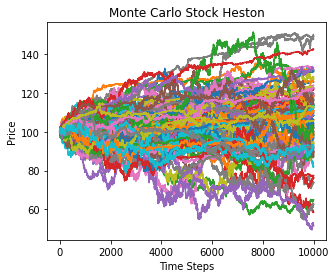

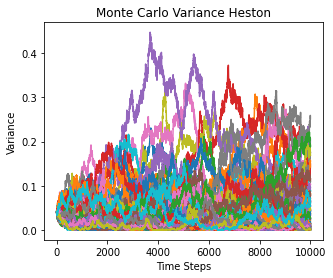

Text(0, 0.5, 'Payoff')

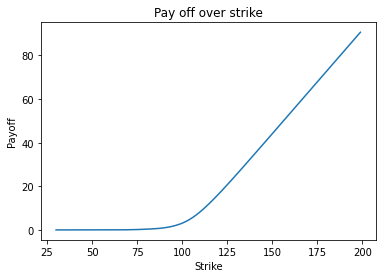

In [7]:
# declare hyperparameter
# monte carlo simulation of stochastic processes
# graph potential pay off over strike 
v_0 =  0.04
sig = 0.6
kappa =2
theta = 0.04
paths =100
steps = 10000
T = 1
rho = -0.5
rhotwo=-0.7
rhothree=-0.1
r = 0.05
S = 100


prices,vols = heston_paths(S, T, r, kappa, theta,
                                    v_0, rho, sig, steps, paths,
                                    )        
## monte carlo of S_t
plt.figure(figsize=(5,4))
plt.plot(prices.T)# dont forget the transpose!
plt.title('Monte Carlo Stock Heston')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()
## monte carlo of the variance of S_t
plt.figure(figsize=(5,4))
plt.plot(vols.T)
plt.title('Monte Carlo Variance Heston')
plt.xlabel('Time Steps')
plt.ylabel('Variance')
plt.show()


## create a discrete strike line 
strikethree =np.arange(30, 200,1)

puts = [] 
## using equation from above the potential pay off over strike under martingale measure
for K in strikethree:
    P = np.mean(np.maximum(K-prices,0))*np.exp(-r*T)
    puts.append(P)
    
plt.plot(strikethree,puts)
plt.title('Pay off over strike')
plt.xlabel('Strike')
plt.ylabel('Payoff')


**Parameter investigation** Clearly it is a random process so we cannot do simple parameter investigation by plugging in different models, we must use monte carlo and analyze how the distribution of these models are impacted. This is achieved using the seaborn.kdeplot, which simply graphs the distrubtion of several curves. We look at how the stock price and volatility are impacted by rho(the correlation), theta(mean of stock) and kappa(mean-reverting rate of the stock diffusion). 

Text(0.5, 1.0, 'Distribution of Vol of stock price by$\\kappa')

) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


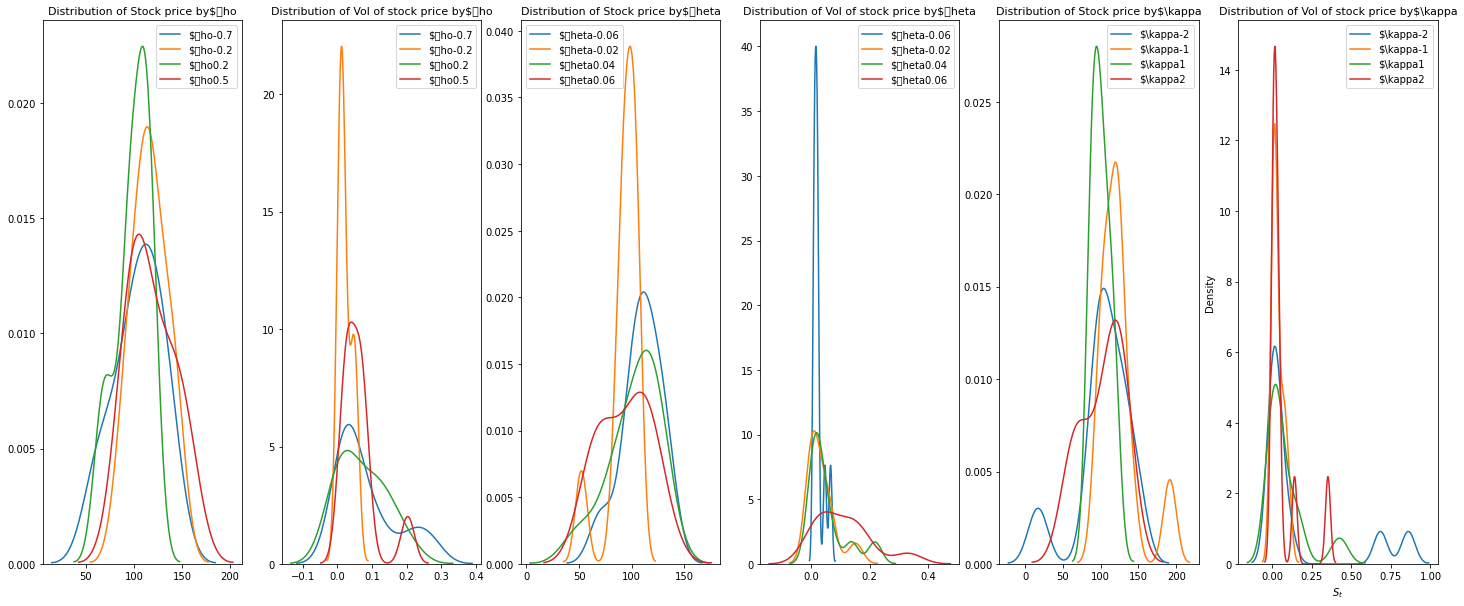

In [191]:
import seaborn as sns

fig,(ax,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(25, 10))


v_0 =  0.04
sig = 0.6
kappa =2
theta = 0.04
paths =10
steps = 10
T = 1
rho = -0.5
r = 0.05
S = 100
# vector of rhos to investigate the impact of the pareameter on Heston model
R=[-0.7,-0.2,0.2,0.5]
Th=[-0.06,-0.02,0.04,0.06]
Kap=[-2,-1,1,2]
str1='$\rho'
str2='$\theta'
str3='$\kappa'


#ax = sns.kdeplot(data=prices[:,-1] ,label=r"$\rho = -0.5$", ax=ax)
#ax= sns.kdeplot(data=vols[:,-1] ,label=r"$\rho = -0.5$", ax=ax)
for e, f in enumerate(R):
    
    rhominus, volminus=heston_paths(S, T, r, kappa, theta,v_0, f, sig, steps, paths) # enumrating through R
    thetaminus,voltheta=heston_paths(S, T, r, kappa, Th[e],v_0, rho, sig, steps, paths) # looping through TH[e]
    kappaminus,volkap=heston_paths(S, T, r, Kap[e], theta,v_0, rho, sig, steps, paths) # looping through Kap[e]
    
    ax = sns.kdeplot(data=rhominus[:,-1] ,label=str1+str(f), ax=ax)
    ax2 = sns.kdeplot(data=volminus[:,-1] ,label=str1+str(f), ax=ax2)
    ax3 = sns.kdeplot(data=thetaminus[:,-1] ,label=str2+str(Th[e]), ax=ax3)
    ax4 = sns.kdeplot(data=voltheta[:,-1] ,label=str2+str(Th[e]), ax=ax4)
    ax5 = sns.kdeplot(data=kappaminus[:,-1] ,label=str3+str(Kap[e]), ax=ax5)
    ax6 = sns.kdeplot(data=volkap[:,-1] ,label=str3+str(Kap[e]), ax=ax6)
    
    
plt.xlabel('$S_t$')
plt.ylabel('Density')
ax.set_title("Distribution of Stock price by"+str1, fontsize=11)    
ax2.set_title("Distribution of Vol of stock price by"+str1, fontsize=11)
ax3.set_title("Distribution of Stock price by"+str2, fontsize=11)    
ax4.set_title("Distribution of Vol of stock price by"+str2, fontsize=11)
ax5.set_title("Distribution of Stock price by"+str3, fontsize=11)    
ax6.set_title("Distribution of Vol of stock price by"+str3, fontsize=11)

**Conlusion**

Clearly we have not calibrated our model to a particular stock so this pay off graph is meaningless, this was just to get our hands dirty with some Python and mathematical finance/Stochastic Calculus. Monte Carlo simulations are a powerful tool as we increase the number of iterations our results will continue to approach the average expected result due to the law of large numbers. 

Later we will show using Ito's lemma the process for constructing the Heston option pricing PDE is similar to Black-Scholes; in the sense that you construct a risk free portforlio by hedging, but now the portforlio is dependent upon the volatility.



## **Deriving the Call Option PDE**
Here are my notes for deriving the option price from Heston's model based upon the text The Volatility Surface by Jim Gatheral, this paper recommended on QuantStackexchange https://www-users.cse.umn.edu/~bemis/IMA/MMI2008/calibrating_heston.pdf, and this github repo https://github.com/CalebMigosi/code-more/tree/8eec3677944b018f21307f5de0636663d51250f9/EquityOptionsPricing. 
![alt text](firstd.jpg)
![alt text](secondd.jpg)
![alt text](thirdd.jpg)
![alt text](fourthd.jpg)
![alt text](fifthd.jpg)


*Now we will derive the Delta and Vega option greeks* typically based on Black-Scholes option price this time based on the Heston European Call option using simple calculus:
![alt text](deltaheston.jpg)
![alt text](vegaheston.jpg)
The master thesis: https://scholarworks.rit.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=5813&context=theses

**What next?**
Since we have derived an equation for the call option given stochastic volatility how do we apply it? Our closed form solution is fit over parameter space anaglous to a nonlinear regression problem minimizing the RMSE or whatever choice of cost function. In this representation of Heston our parameter space is given by params=(sigma, kappa, theta, volvol, rho). 
Our goal is to minimize the MSE
\begin{array}
\\ \\ MSE &=& \frac{1}{N} \Sigma (realprice-HestonPrice(St,Strikes,Ttm,params))^2
\end{array}

Now in order to preform this calibration process for the parameters of a closed form call option requires actual prices from the market, thus a datapipeline must be created. A harder way to do this is via webscrapping, where one utilizes Python modules/libraries to dig through the html and javascipt of a webpage and automate the extarction of data needed; however I will be keeping it simple just by looping through Excel files from the website https://www.barchart.com/stocks/quotes/$SPX/options where it is free to download option prices. Yahoo Finance options data was sadly taken down in 2020. 


In [2]:
from numba import jit, njit,float64, prange
from lmfit import Parameters, minimize
import pandas as pd 
import numpy as np
from scipy.optimize import dual_annealing
from scipy.optimize import fmin_slsqp
from scipy.optimize import minimize
import traceback
#from numba import cumba 

i=complex(0,1)


**Data Preprocessing**: All we have to do really in terms of preprocessing is extract the data from the excel files and 'vectorize' the data properly so it can be fed into our Heston model. In this example I consider 20 different strike prices over 5 different maturities, which is 100 data points in total; I have 5 excel files and each of them contain 20 call options that expire in a certain week, for first file they expire next week, for the second file they expire in 2 weeks, and etc. The simplest way to extract 20 prices from 5 different files is to create an array of strings with the names of the excel files and enumerate through the file names and append all the prices in that csv. After we have collected all of our prices, strikes and maturities, a classical volatility surface can be constructed. An issue came up with the striketwo array being a string but it must be a float for our computations despite using the astype command I was unable to override the string array hence I made a striketwo array using while loops. 

In [3]:
import os
path = 'newopt/'
maturities=[1/48,2/48,3/48,1/12,5/48]
filenames = ['firstopt.csv','secondopt.csv','thirdopt.csv','fourthopt.csv','fifthopt.csv']
optionprices=[]
strikestwo=[]

for e, f in enumerate(filenames):
    with open(path+f,'r') as file:
        frame=pd.read_csv(file)

        strikestwo=(frame.Strike.iloc[0:20])# select the call options
        optionprices.append(frame.Midpoint.iloc[0:20])

strikestwo=np.array(strikestwo)
optionprices=np.array(optionprices)                
volsurfer=pd.DataFrame(optionprices,index = maturities, columns = strikestwo)

striketwo=[]
t=4345
while t<4445:
    t+=5
    striketwo.append(t)

    
print(volsurfer.head())
striketwo=np.array(striketwo)
print(striketwo.shape)


          4,350.00  4,355.00  4,360.00  4,365.00  4,370.00  4,375.00  \
0.020833     95.95      92.7     89.45     87.60     84.90     81.55   
0.041667    119.15     116.9    111.00    108.50    106.15    102.55   
0.062500    134.85     131.6    127.75    126.40    123.65    119.75   
0.083333    143.75     140.6    137.90    134.30    131.20    128.10   
0.104167    154.95     151.9    148.85    145.55    142.35    139.35   

          4,380.00  4,385.00  4,390.00  4,395.00  4,400.00  4,405.00  \
0.020833     78.10     75.90     72.95      68.5     65.85     62.80   
0.041667     99.80     97.75     93.80      90.5     87.90     85.10   
0.062500    115.90    112.90    109.95     105.0    102.10     99.60   
0.083333    125.05    122.05    119.05     116.1    113.20    110.25   
0.104167    136.55    133.50    130.30     127.1    124.20    121.25   

          4,410.00  4,415.00  4,420.00  4,425.00  4,430.00  4,435.00  \
0.020833     60.55     58.60     55.50     53.00     50.55    

In [4]:

## Another data I hand scraped was just curious to test out 

sigma, kappa, theta, volvol, rho = 0.1, 0.1, 0.1, 0.1, 0.1
params=[sigma, kappa, theta, volvol, rho]
strikes=[4650,4655,4660,4665,4670]
marketPrices=[70.00,66.70,63.50,60.35,57.30,82.50,79.20,76.0,72.80,69.70,92.65,89.35,86.10,82.90,79.75,101.60,98.30,95.10,91.90,88.75,109.85,106.60,103.35,100.20,97.00]
marketPrices=np.array(marketPrices)
rates=[0.05,0.05,0.05,0.05,0.05]
St=4398
np.shape(marketPrices)



(25,)

**Finally time to type in equations we worked so hard to derive**
If you had a hard time reading my handwriting sorry!
![alt text](sixthd.jpg)
https://github.com/CalebMigosi/code-more/blob/8eec3677944b018f21307f5de0636663d51250f9/EquityOptionsPricing/Heston%20Pricing%201.ipynb
The integral simply becomes a sum in the discrete, also as recommended in the github above I will use the midpoint approximation for Riemannian sums as integration scheme. Another isssue is that the output of the model over strikes and maturities needs to be vectorized for the objective function, in order to do that we simply loop through all strikes and maturities and append the price to an array. Since we are doing so many different for loops it is also worth it to try and parallelize the loops using the prange feature from the Numba module.  

In [14]:
# Let us parallelize our code for efficency 
@jit
def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):

    prod = rho * sigma *i *s 
    
    d1 = (prod - kappa)**2
    d2 = (sigma**2) * (i*s + s**2)
    d = np.sqrt(d1 + d2)

    g1 = kappa - prod - d
    g2 = kappa - prod + d
    g = g1/g2
    exp1 = np.exp(np.log(St) * i *s) * np.exp(i * s* r* T)
    exp2 = 1 - g * np.exp(-d *T)
    exp3 = 1- g
    mainExp1 = exp1 * np.power(exp2/ exp3, -2 * theta * kappa/(sigma **2))
    
    exp4 = theta * kappa * T/(sigma **2)
    exp5 = volvol/(sigma **2)
    exp6 = (1 - np.exp(-d * T))/(1 - g * np.exp(-d * T))
    mainExp2 = np.exp((exp4 * g1) + (exp5 *g1 * exp6))
    
    return (mainExp1 * mainExp2)

# Return P(XT>X)
# P=P_0 from Heston Ansatz
@jit(forceobj=True)
def probHeston(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    
    
    # integral
    # j not i 
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        # get rid of the Kscale its not needed for probability
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) *i *s1
        
        P = P + (ds *numerator1)/denominator
    
    element2 = P/np.pi
    
    return np.real((element2))

@jit(forceobj=True)
def deltaHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
    # integral
    # j not i 
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        denominator = St*np.exp(np.log(K) * i * s1) *i *s1
        denominator2 = np.exp(np.log(K) * i * s1) *i *s1
        P = P + ds *(numerator1 - numerator2)/denominator
        P2=P + (ds *numerator2)/denominator2
    
    element2 = P/np.pi +P2/np.pi
    
    return np.real((element1 + element2))


def vegaaHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
   
    # integral
    # j not i 
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        prod = rho * sigma *i *s1
        prod2 = rho * sigma *i *s2
        #now entering our d's from earlier 
        d1 = (prod - kappa)**2
        d1_ = (prod2 - kappa)**2
        d2 = (sigma**2) * (i*s1 + s1**2)
        d2_= (sigma**2) * (i*s2 + s2**2)
        d3 = np.sqrt(d1 + d2)
        d3_ = np.sqrt(d1_ + d2_)
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)*d3
        numerator2 = K * fHeston(s1,  St, K, r, T, sigma, kappa, theta, volvol, rho)*d3_
        denominator = St*np.exp(np.log(K) * i * s1) *i *s1*i*s1
        P = P + ds *(numerator1 - numerator2)/denominator
    
    element2 = P/np.pi
    
    return np.real((element1 + element2))

@jit(forceobj=True)
def priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
    # integral
    # j not i 
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) *i *s1
        P = P + ds *(numerator1 - numerator2)/denominator
    
    element2 = P/np.pi
    
    return np.real((element1 + element2))

        

@jit(forceobj=True)
def strikematurePriceHestonMid(St, W, r, Q, sigma, kappa, theta, volvol, rho):
    stuff=[]
    volsur=[]
    e=0
    p=0
    for e in prange(len(Q)):
        for p in prange(len(W)):
            stuff.append(priceHestonMid(St, W[p], r, Q[e], sigma, kappa, theta, volvol, rho))
            
            #print(priceHestonMid(St, W[e], r, Q[p], sigma, kappa, theta, volvol, rho))
    
    #volsur=np.reshape(stuff,(20,5))
    stuff=np.array(stuff)
    return stuff

**Test equations** 
Now it is worth it to simulate using random paramters like we did earlier for the Heston stock price SDE, make sure our dimensions for our arrays correct and if issues come up.

In [44]:

# random simulation!
#strikeprice(4662,strikes,0.05,1/12,1.32,1.23,-1.16,0.004,2)
strikematurePriceHestonMid(4389,striketwo,0.05,maturities,1.32,1.23,-1.16,0.004,2)

array([-1265.07515821, -1285.22804682, -1293.48108959, -1289.77453333,
       -1274.16046064, -1246.80187613, -1207.97070402, -1158.04472658,
       -1097.5035033 , -1026.92332097,  -946.97123385,  -858.39826202,
        -762.03182366,  -658.76748389,  -549.56010875,  -435.41451797,
        -317.37573373,  -196.51892597,   -73.93915611,    49.25897804,
       -2904.70927667, -2967.97650829, -3016.26651836, -3049.1228417 ,
       -3066.19973782, -3067.26519732, -3052.20291952, -3021.01324962,
       -2973.81307437, -2910.83468549, -2832.42362996, -2739.03557627,
       -2631.23223497, -2509.67638044, -2375.12602937, -2228.42783851,
       -2070.5097912 , -1902.37324835, -1725.0844441 , -1539.76551128,
       -3951.4806062 , -3985.94428411, -4005.11709676, -4008.87103277,
       -3997.17740179, -3970.1065859 , -3927.82696609, -3870.60304091,
       -3798.79276214, -3712.84411948, -3613.29101255, -3500.74845523,
       -3375.9071627 , -3239.5275767 , -3092.43338923, -2935.50462846,
      

In [43]:

## probability of St being greather than the strike price on expiration
probHestonmid(St,striketwo[0],rates[0],maturities[0],0.756,1.5669,0.337,0.0713,-0.899)

0.14092894011029308

In [16]:
deltaHestonMid(St,striketwo[0],rates[0],maturities[0],0.756,1.5669,0.337,0.0713,-0.899)

26.290957067135437

In [15]:
vegaaHestonMid(St,striketwo[0],rates[0],maturities[0],0.756,1.5669,0.337,0.0713,-0.899)

28.071964691054514

**Creating objective function** Since we have our preprocessed array of prices and our vectorized Heston function strikematurePriceHestonmid all we have to do is create an objective function subtracting these arrays and summing all the entries; an easy way to do this is using the dot product. I could have added regularization terms to the objective or raised it by a different power p, but out of simplicity I chose norm p=1 and no other additions. 
The easiest way to optimize this function is via SciPy or another module with built in optimizers as calibrating the hyperparameters for your own custom optimizer is an especially cumbersome task with the Heston model, to be frank it was a lot easier calibrating hyperparameters for a quantum circuit then for a Heston model, trust me I will show you later. The minimize function in SciPy requires parameter space to be declared as an array called x and all the other constants as args. I chose to use Nelder-mead, but SLSQP is fine and I encourage people to explore others.

In [338]:

def objectiveFunctionHeston(x,St, strikest,rates, maturities):

    objective = ((optionprices.reshape(100))-(strikematurePriceHestonMid(St, strikest,  
                                                                        rates, 
                                                                       maturities, 
                                                                        sigma=x[0],                         
                                                                        kappa=x[1],
                                                                        theta=x[2],
                                                                        volvol=x[3],
                                                                        rho=x[4])))
    objective=np.square(np.dot(objective,objective))
    return objective




#fmin_slsqp(objectiveFunctionHeston,params)
bounds=((1e-2,5),(1e-2,8),(1e-2,10),(1e-2,10),(-1,1))
res = minimize(objectiveFunctionHeston, method='Nelder-mead',  x0=[sigma, kappa, theta, volvol, rho],args=(St,striketwo,rates[0],maturities),
                  bounds = bounds, tol=1e-20, 
                    options={"maxiter":3000})
print(res)



/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)


 final_simplex: (array([[ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483],
       [ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483],
       [ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483],
       [ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483],
       [ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483],
       [ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483]]), array([13904.58540344, 13904.58540344, 13904.58540344, 13904.58540344,
       13904.58540344, 13904.58540344]))
           fun: 13904.585403441763
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 13310
           nit: 3000
        status: 2
       success: False
             x: array([ 0.75566084,  1.56692873, -0.3376484 ,  0.07139091, -0.89965483])


**Training is done**: After the calibrating we want to test the model, so we should plug in our optimial parameters from our res and see what our strikematurePriceHestonMid yields. I did this for 1000 iterations(more than an hour) and 3000 iterations(took around 4 and a half hours). Below I print the residual surface 

In [329]:


# residuals at iterations=1000 print(strikematurePriceHestonMid(St,striketwo,rates[0],maturities,0.742,1.287,0.418,0.0710,-0.892)-optionprices.reshape(100))
# I forgot to calculate the percent error did not have enough time to re run model 

[ 3.75245618  3.83922976  3.97744935  2.76766583  2.46040523  2.8561682
  3.40542943  2.758637    2.91621171  4.62854625  4.59600435  5.01891982
  4.69759557  4.13230253  4.77327846  4.87072678  4.97481534  4.98567508
  5.10339878  5.0780397  13.65074254 12.82614105 15.68723354 15.1843539
 14.56782776 15.23797165 15.09509227 14.28948566 15.42143648 15.94121726
 15.79908768 15.89529388 16.28006781 16.25362663 16.3661721  16.41789011
 16.50895014 16.58950488 16.65968983 16.61962302 25.57326925 25.78827723
 26.63165375 25.00357599 24.80421831 25.78375234 26.74234696 26.88016842
 26.99738029 29.14414343 29.27061596 29.02695315 29.0633073  29.17982761
 29.77665998 29.85394677 29.96182663 30.00043417 29.71989971 29.67034894
 41.53270271 41.66611005 41.37363324 42.00541121 42.16157898 42.3422677
 42.49760463 42.62771324 42.78271322 42.91272061 43.01784781 43.19820373
 43.25389385 43.43502035 42.64168218 43.62397519 42.88199222 43.81582318
 43.87555514 43.81127244 53.50641266 53.55301293 53.62

In [340]:

## residuals at iterations=3000 print(strikematurePriceHestonMid(St,striketwo,rates[0],maturities,0.756,1.5669,0.337,0.0713,-0.899)-optionprices.reshape(100))

[ 3.77084627  3.85449884  3.98950126  2.77640194  2.46572495  2.85796959
  3.40360993  2.7530943   2.9068446   4.61525566  4.57869438  4.99749888
  4.67197754  4.1024079   4.73903557  4.83207301  4.93169827  4.93805365
  5.05124438  5.02133722 13.46732875 12.63557818 15.48947697 14.97937265
 14.35560464 15.01850342 14.86838963 14.05557318 15.18035241 15.69301328
 15.5438285  15.63305684 16.01094238 15.9777138  16.0835838  16.12874854
 16.21338706 16.28766091 16.35171372 16.30567085 25.09289129 25.29959661
 26.13462743 24.49816193 24.2903763  25.26144494 26.21154048 26.3408339
 26.44949446 28.58768973 28.70558548 28.45334555 28.48113175 28.58910359
 29.17741808 29.24622943 29.34568876 29.3759437  29.08713808 29.02941147
 40.68056881 40.80385168 40.5013268  41.12313292 41.26940459 41.44027217
 41.585862   41.70629647 41.85169421 41.97217023 42.06783607 42.23879997
 42.28516708 42.45703958 41.65451688 42.62769581 41.8766707  42.80153362
 42.85237442 42.77928088 52.23898234 52.27336427 52.

In [72]:
probHeston(St,striketwo[11],rates[0],maturities[4],0.756,1.5669,0.337,0.0713,-0.899)
probs=[]
o=0
for o in range(len(maturities)):
    for n in range(len(striketwo)):
        probs.append(probHeston(St,striketwo[n],rates[0],maturities[o],0.756,1.5669,0.337,0.0713,-0.899))
print((probs))


[0.14092894011029308, 0.13065598434933295, 0.12024957343937406, 0.10971521510730904, 0.09905875942545062, 0.08828639641008176, 0.07740465222641403, 0.06642038395060818, 0.05534077284866252, 0.04417331614012814, 0.03292581722453533, 0.02160637435806664, 0.010223367778404555, -0.0012145547133723341, -0.012698493694756079, -0.024219315556982812, -0.03576767139184432, -0.04733401727813869, -0.058908635903930355, -0.07048165945161176, 0.12081499507090179, 0.1136530383957715, 0.10642842832541727, 0.09914295525562858, 0.09179848298372661, 0.08439694771858594, 0.07694035700051319, 0.0694307885393166, 0.06187038897934858, 0.05426137259949988, 0.04660601995600545, 0.0389066764751737, 0.031165751002532407, 0.02338571431428877, 0.015569097595709253, 0.0077184908904459944, -0.0001634584762521433, -0.008074047498944548, -0.016010519116925248, -0.02397006386363884, 0.11391333869621088, 0.10820762992888697, 0.10246095629406979, 0.09667409479817436, 0.09084785600013437, 0.08498308446932458, 0.079080659

**Conclusion** Notice as we increasre maturity the probability of the Heston expiring in the money decreases which makes sense intuitively we are less sure about events further in the future. Also you see that calls with lower strike price have higher probability indicating a more bearish sentiment in the market, which indeed is true it just had one of the worst 'crashes'(it was a far overdue correction) since 87'. Also increasing the iterations from 1000 to 3000 did virtually nothing to the parameters only very small changes likely within the range of certainity at 1000 p=(0.742,1.287,0.418,0.0710,-0.892) and at 3000 p=(0.756,1.5669,0.337,0.0713,-0.899). Also the residuals intuitively increase over maturity as expected. 

**Custom Optimizer** We will use the notorious SPSA global optimizer developed by Prof. James C. Spall at John Hopkins, I personally used this optimizer for optimizing quantum circuits to produce the ground state energy of Hydrogen ions; this algorithm known as VQE. Here is the psuedocode for the optimization process, its akin to gradient descent except the gradient is estimated by finite difference and there is sampling of parameters from a binomial distrubition. Not only that but it has alot of other hyperparameters than gradient descent which makes calibrating the optimizer a hassle. For regular functions and quantum circuits my research collague was able to get the hyperparameters simply by messing around with them for a few minutes. For the Heston process I tried for around a couple of hours of calibrating the optimizer,then I became desperate so I tried line search methods and nothing seemed to work so I just used SciPy as you saw above. Anyways just wanted to include this SPSA to show the failed attempt. As you can see it is obtaining nonsense values in parameter space outrageously high numbers as the gradient is not pointing in the correct direction. 
![alt text](spsac.jpg)
https://www.jhuapl.edu/spsa/PDF-SPSA/Spall_An_Overview.PDF

In [129]:


def SPSA(alpha,gamma,lowa,A,c,iterations,theta,tol):
    dimension=len(theta)
    
    
    # declare vector function quantities
   # gradient=np.zeros(dimension)
    #delta=np.zeros(dimension)
    #yplus=np.zeros(dimension)
    #yminus=np.zeros(dimension)
    #thetaplus=np.zeros(dimension)
    #thetaminus=np.zeros(dimension)
   
    # constructing +/- 1 bernoulli 
    
    # simple for loop implementation as variables iterate
    r=0
    counter=0
    while r<=iterations:
        
        ak=a/(r+1+A)**alpha
        ck=c/(r+1)**gamma
        
        
        delta=np.random.binomial(1,.5, dimension)
        j=0
        for j in range(dimension):
            if delta[j]==0:
                delta[j]=-1
        #delta=2*delta-1
        print('*this is our delta:{}'.format(delta))
       
        thetaplus=theta+ck*delta
        thetaminus=theta-ck*delta
    
        r+=1
        yplus=objectiveFunctionHeston(4662,strikes,rates[0],maturities,thetaplus[0],thetaplus[1],thetaplus[2],thetaplus[3],thetaplus[4])
        yminus=objectiveFunctionHeston(4662,strikes,rates[0],maturities,thetaminus[0],thetaminus[1],thetaminus[2],thetaminus[3],thetaminus[4])
        print("**** @ {} iteration ****".format(r))
        print("   - (yplus-yminus): {}".format(yplus-yminus))
        gradient=delta*(yplus-yminus)/(2*ck)
        blrt=theta
        theta=theta-ak*gradient
        fthe=objectiveFunctionHeston(4662,strikes,rates[0],maturities,theta[0],theta[1],theta[2],theta[3],theta[4])
        fblrt=objectiveFunctionHeston(4662,strikes,rates[0],maturities,blrt[0],blrt[1],blrt[2],blrt[3],blrt[4])
        #diff=abs(fthe[0]-fblrt[0])
        #print('difference of F(i) and F(i+1)',diff)
        #convergence criterion
        
        if np.all([theta,blrt]):
            counter+=1

            if counter==1000:
                            
                print('Convergence reached @',fthe)
                #print('diff',diff)
                print('tol',tol)
                print('theta',theta)
                print('previous theta',blrt)
                break
        else:
            print('blrt',blrt)
            #print('theta',theta)
            
        #if np.linalg.norm(gradient)==0:
            #print('gradient is zero')
            #break 
        #else:
            print(' - (theta): {}'.format(theta))
            print(' - F(theta): {}'.format(fthe))

alpha = 0.4
gamma = 0.1
a = 0.1
A = 0.02
c = 0.03
theta = [0.1,0.1,0.1,0.1,0.1]
iterations=1000
tol=1e-4
SPSA(alpha,gamma,a,A,c,iterations,theta,tol)     

*this is our delta:[-1  1  1 -1  1]
**** @ 1 iteration ****
   - (yplus-yminus): -565.8923878614213
*this is our delta:[-1  1  1 -1 -1]
**** @ 2 iteration ****
   - (yplus-yminus): -0.00045543002840631175
*this is our delta:[ 1  1  1  1 -1]
**** @ 3 iteration ****
   - (yplus-yminus): -0.0009258142249262136
*this is our delta:[ 1  1 -1  1  1]
**** @ 4 iteration ****
   - (yplus-yminus): -4.926030435647988e-05
*this is our delta:[-1  1 -1 -1  1]
**** @ 5 iteration ****
   - (yplus-yminus): 0.00041578450388257693
*this is our delta:[ 1 -1 -1 -1  1]
**** @ 6 iteration ****
   - (yplus-yminus): 0.0005160110188384692
*this is our delta:[-1 -1  1  1 -1]
**** @ 7 iteration ****
   - (yplus-yminus): -5.9813831885691116e-05
*this is our delta:[-1 -1 -1  1  1]
**** @ 8 iteration ****
   - (yplus-yminus): 0.00073414200173616
*this is our delta:[ 1 -1  1 -1  1]
**** @ 9 iteration ****
   - (yplus-yminus): 4.5439256000534556e-05
*this is our delta:[-1  1 -1  1 -1]
**** @ 10 iteration ****
   - (ypl

**** @ 79 iteration ****
   - (yplus-yminus): -0.0003151308296800437
*this is our delta:[ 1  1 -1 -1 -1]
**** @ 80 iteration ****
   - (yplus-yminus): -0.00022081999879475234
*this is our delta:[ 1  1 -1  1  1]
**** @ 81 iteration ****
   - (yplus-yminus): -3.646244197774706e-05
*this is our delta:[-1 -1  1 -1  1]
**** @ 82 iteration ****
   - (yplus-yminus): 0.0003033822945699427
*this is our delta:[-1  1 -1 -1  1]
**** @ 83 iteration ****
   - (yplus-yminus): 0.0003135693537643647
*this is our delta:[ 1  1 -1  1 -1]
**** @ 84 iteration ****
   - (yplus-yminus): -0.00030275181893735237
*this is our delta:[ 1 -1 -1  1 -1]
**** @ 85 iteration ****
   - (yplus-yminus): 4.626017006259531e-05
*this is our delta:[ 1  1  1  1 -1]
**** @ 86 iteration ****
   - (yplus-yminus): -0.000660850425585835
*this is our delta:[-1 -1  1 -1  1]
**** @ 87 iteration ****
   - (yplus-yminus): 0.00030166097746153753
*this is our delta:[-1 -1 -1 -1 -1]
**** @ 88 iteration ****
   - (yplus-yminus): 0.000394083

**** @ 157 iteration ****
   - (yplus-yminus): 0.00020622183356522328
*this is our delta:[ 1  1 -1  1 -1]
**** @ 158 iteration ****
   - (yplus-yminus): -0.0002839146074862242
*this is our delta:[-1 -1 -1  1 -1]
**** @ 159 iteration ****
   - (yplus-yminus): 0.0002933818344637018
*this is our delta:[ 1 -1 -1 -1  1]
**** @ 160 iteration ****
   - (yplus-yminus): 0.0003708997501430389
*this is our delta:[ 1  1 -1  1 -1]
**** @ 161 iteration ****
   - (yplus-yminus): -0.00028343603153757613
*this is our delta:[ 1  1 -1  1 -1]
**** @ 162 iteration ****
   - (yplus-yminus): -0.00028319898862072534
*this is our delta:[-1 -1  1 -1  1]
**** @ 163 iteration ****
   - (yplus-yminus): 0.0002830434783778202
*this is our delta:[-1 -1 -1 -1  1]
**** @ 164 iteration ****
   - (yplus-yminus): 0.000618926134070108
*this is our delta:[-1 -1 -1 -1  1]
**** @ 165 iteration ****
   - (yplus-yminus): 0.0006185173934749599
*this is our delta:[ 1  1 -1  1  1]
**** @ 166 iteration ****
   - (yplus-yminus): -3.

*this is our delta:[ 1 -1  1 -1 -1]
**** @ 235 iteration ****
   - (yplus-yminus): -0.00020734270740518923
*this is our delta:[-1 -1  1  1 -1]
**** @ 236 iteration ****
   - (yplus-yminus): -4.2116370766009936e-05
*this is our delta:[-1 -1 -1 -1 -1]
**** @ 237 iteration ****
   - (yplus-yminus): 0.00035649623304045974
*this is our delta:[-1  1  1 -1  1]
**** @ 238 iteration ****
   - (yplus-yminus): -4.1832755776738395e-05
*this is our delta:[ 1 -1  1 -1  1]
**** @ 239 iteration ****
   - (yplus-yminus): 3.2642418359429826e-05
*this is our delta:[-1 -1  1  1  1]
**** @ 240 iteration ****
   - (yplus-yminus): 0.00019741884186430525
*this is our delta:[-1 -1  1  1  1]
**** @ 241 iteration ****
   - (yplus-yminus): 0.0001972960163545423
*this is our delta:[ 1  1 -1  1 -1]
**** @ 242 iteration ****
   - (yplus-yminus): -0.00027187811646989246
*this is our delta:[ 1 -1  1  1  1]
**** @ 243 iteration ****
   - (yplus-yminus): -4.197340615874623e-05
*this is our delta:[-1 -1  1 -1  1]
**** @ 

*this is our delta:[-1 -1  1 -1 -1]
**** @ 313 iteration ****
   - (yplus-yminus): 3.179231220151735e-05
*this is our delta:[-1 -1 -1 -1 -1]
**** @ 314 iteration ****
   - (yplus-yminus): 0.000346430635765671
*this is our delta:[-1 -1  1  1 -1]
**** @ 315 iteration ****
   - (yplus-yminus): -4.0918772731046715e-05
*this is our delta:[ 1 -1  1  1  1]
**** @ 316 iteration ****
   - (yplus-yminus): -4.093477263644729e-05
*this is our delta:[ 1 -1  1 -1  1]
**** @ 317 iteration ****
   - (yplus-yminus): 3.1787481075795654e-05
*this is our delta:[-1 -1  1 -1  1]
**** @ 318 iteration ****
   - (yplus-yminus): 0.0002644218694580758
*this is our delta:[ 1 -1 -1  1  1]
**** @ 319 iteration ****
   - (yplus-yminus): 0.00027322305429500204
*this is our delta:[ 1 -1 -1 -1  1]
**** @ 320 iteration ****
   - (yplus-yminus): 0.00034574437889212106
*this is our delta:[-1  1 -1 -1  1]
**** @ 321 iteration ****
   - (yplus-yminus): 0.0002734263565358219
*this is our delta:[ 1 -1 -1  1  1]
**** @ 322 ite

*this is our delta:[-1 -1  1 -1 -1]
**** @ 391 iteration ****
   - (yplus-yminus): 3.1106635143274275e-05
*this is our delta:[-1  1 -1 -1 -1]
**** @ 392 iteration ****
   - (yplus-yminus): 4.000600120512843e-05
*this is our delta:[-1 -1 -1 -1  1]
**** @ 393 iteration ****
   - (yplus-yminus): 0.0005661802822487516
*this is our delta:[-1  1 -1  1 -1]
**** @ 394 iteration ****
   - (yplus-yminus): -3.111467391647693e-05
*this is our delta:[-1  1  1  1  1]
**** @ 395 iteration ****
   - (yplus-yminus): -0.00011092523621769601
*this is our delta:[-1 -1 -1  1  1]
**** @ 396 iteration ****
   - (yplus-yminus): 0.000494758605437795
*this is our delta:[ 1 -1  1 -1 -1]
**** @ 397 iteration ****
   - (yplus-yminus): -0.0001963649396650169
*this is our delta:[-1 -1 -1  1 -1]
**** @ 398 iteration ****
   - (yplus-yminus): 0.00026707269316617044
*this is our delta:[ 1  1  1  1 -1]
**** @ 399 iteration ****
   - (yplus-yminus): -0.0005652700351639339
*this is our delta:[ 1 -1  1  1  1]
**** @ 400 it

*this is our delta:[-1  1 -1  1  1]
**** @ 469 iteration ****
   - (yplus-yminus): 0.00019289248364628975
*this is our delta:[-1 -1  1  1  1]
**** @ 470 iteration ****
   - (yplus-yminus): 0.00018417248274360531
*this is our delta:[ 1 -1  1  1  1]
**** @ 471 iteration ****
   - (yplus-yminus): -3.915285339850527e-05
*this is our delta:[-1 -1 -1  1  1]
**** @ 472 iteration ****
   - (yplus-yminus): 0.000485970980170336
*this is our delta:[ 1 -1  1  1 -1]
**** @ 473 iteration ****
   - (yplus-yminus): -0.0002626186501224481
*this is our delta:[-1  1  1  1 -1]
**** @ 474 iteration ****
   - (yplus-yminus): -0.000332199533186639
*this is our delta:[-1 -1  1  1 -1]
**** @ 475 iteration ****
   - (yplus-yminus): -3.9238349611281365e-05
*this is our delta:[-1 -1  1 -1 -1]
**** @ 476 iteration ****
   - (yplus-yminus): 3.0459803147309117e-05
*this is our delta:[ 1  1 -1  1  1]
**** @ 477 iteration ****
   - (yplus-yminus): -3.0511351019057997e-05
*this is our delta:[ 1  1 -1  1  1]
**** @ 478 

**** @ 546 iteration ****
   - (yplus-yminus): 0.00025017946010841285
*this is our delta:[-1  1  1  1  1]
**** @ 547 iteration ****
   - (yplus-yminus): -0.00010726774879010748
*this is our delta:[ 1  1  1 -1 -1]
**** @ 548 iteration ****
   - (yplus-yminus): -0.0004784336070997597
*this is our delta:[-1 -1  1  1  1]
**** @ 549 iteration ****
   - (yplus-yminus): 0.0001812091729487264
*this is our delta:[ 1 -1  1 -1  1]
**** @ 550 iteration ****
   - (yplus-yminus): 2.998760798256228e-05
*this is our delta:[-1 -1  1  1  1]
**** @ 551 iteration ****
   - (yplus-yminus): 0.00018106592840361202
*this is our delta:[-1  1 -1  1 -1]
**** @ 552 iteration ****
   - (yplus-yminus): -2.9988125950453082e-05
*this is our delta:[-1  1  1  1  1]
**** @ 553 iteration ****
   - (yplus-yminus): -0.00010708706477835506
*this is our delta:[-1  1 -1 -1  1]
**** @ 554 iteration ****
   - (yplus-yminus): 0.00025842747599824634
*this is our delta:[-1 -1  1 -1  1]
**** @ 555 iteration ****
   - (yplus-yminus)

*this is our delta:[1 1 1 1 1]
**** @ 624 iteration ****
   - (yplus-yminus): -0.0003229832697080326
*this is our delta:[-1  1  1 -1 -1]
**** @ 625 iteration ****
   - (yplus-yminus): -0.0002550041514037815
*this is our delta:[ 1  1  1  1 -1]
**** @ 626 iteration ****
   - (yplus-yminus): -0.0005398018513140812
*this is our delta:[ 1 -1  1  1  1]
**** @ 627 iteration ****
   - (yplus-yminus): -3.824198370416809e-05
*this is our delta:[ 1 -1 -1 -1  1]
**** @ 628 iteration ****
   - (yplus-yminus): 0.00032266701711414214
*this is our delta:[-1 -1  1 -1 -1]
**** @ 629 iteration ****
   - (yplus-yminus): 2.9757499879323746e-05
*this is our delta:[ 1 -1  1  1  1]
**** @ 630 iteration ****
   - (yplus-yminus): -3.8234790945779196e-05
*this is our delta:[-1  1  1  1  1]
**** @ 631 iteration ****
   - (yplus-yminus): -0.00010582495844779771
*this is our delta:[ 1 -1  1 -1  1]
**** @ 632 iteration ****
   - (yplus-yminus): 2.9597174117768077e-05
*this is our delta:[-1  1 -1 -1  1]
**** @ 633 it

*this is our delta:[ 1 -1  1 -1  1]
**** @ 702 iteration ****
   - (yplus-yminus): 2.9426646484864705e-05
*this is our delta:[-1 -1  1  1  1]
**** @ 703 iteration ****
   - (yplus-yminus): 0.00017675196352406886
*this is our delta:[ 1  1 -1  1  1]
**** @ 704 iteration ****
   - (yplus-yminus): -2.941632399000582e-05
*this is our delta:[-1 -1  1 -1  1]
**** @ 705 iteration ****
   - (yplus-yminus): 0.0002435728632459444
*this is our delta:[-1 -1  1  1  1]
**** @ 706 iteration ****
   - (yplus-yminus): 0.00017649395952368252
*this is our delta:[-1 -1 -1 -1 -1]
**** @ 707 iteration ****
   - (yplus-yminus): 0.0003187308010534906
*this is our delta:[ 1 -1  1  1 -1]
**** @ 708 iteration ****
   - (yplus-yminus): -0.00025190939214247976
*this is our delta:[ 1 -1  1 -1 -1]
**** @ 709 iteration ****
   - (yplus-yminus): -0.00018480175522839204
*this is our delta:[-1  1  1 -1 -1]
**** @ 710 iteration ****
   - (yplus-yminus): -0.00025167910409606975
*this is our delta:[ 1 -1  1 -1  1]
**** @ 71

*this is our delta:[ 1 -1 -1  1  1]
**** @ 780 iteration ****
   - (yplus-yminus): 0.00024906338299324204
*this is our delta:[-1  1 -1  1  1]
**** @ 781 iteration ****
   - (yplus-yminus): 0.00018299214078076886
*this is our delta:[ 1 -1  1  1  1]
**** @ 782 iteration ****
   - (yplus-yminus): -3.7381098421107595e-05
*this is our delta:[ 1 -1 -1  1 -1]
**** @ 783 iteration ****
   - (yplus-yminus): 3.7173652231103915e-05
*this is our delta:[-1  1 -1  1  1]
**** @ 784 iteration ****
   - (yplus-yminus): 0.00018292729829560983
*this is our delta:[ 1 -1 -1 -1 -1]
**** @ 785 iteration ****
   - (yplus-yminus): 0.00010338514627505901
*this is our delta:[-1  1  1 -1 -1]
**** @ 786 iteration ****
   - (yplus-yminus): -0.0002489386292978679
*this is our delta:[ 1 -1 -1  1 -1]
**** @ 787 iteration ****
   - (yplus-yminus): 3.7167650864589064e-05
*this is our delta:[-1 -1  1  1  1]
**** @ 788 iteration ****
   - (yplus-yminus): 0.0001745466057272438
*this is our delta:[ 1 -1 -1 -1 -1]
**** @ 789

*this is our delta:[ 1 -1 -1  1 -1]
**** @ 858 iteration ****
   - (yplus-yminus): 3.6798928073622506e-05
*this is our delta:[ 1  1 -1 -1 -1]
**** @ 859 iteration ****
   - (yplus-yminus): -0.00017284140954387794
*this is our delta:[-1 -1 -1  1 -1]
**** @ 860 iteration ****
   - (yplus-yminus): 0.00024663621963938454
*this is our delta:[-1 -1 -1  1  1]
**** @ 861 iteration ****
   - (yplus-yminus): 0.0004563545184943507
*this is our delta:[ 1 -1 -1  1  1]
**** @ 862 iteration ****
   - (yplus-yminus): 0.000246584676503403
*this is our delta:[ 1 -1  1 -1  1]
**** @ 863 iteration ****
   - (yplus-yminus): 2.8837138838611054e-05
*this is our delta:[ 1  1  1 -1  1]
**** @ 864 iteration ****
   - (yplus-yminus): -0.00024651023719890475
*this is our delta:[-1 -1 -1  1  1]
**** @ 865 iteration ****
   - (yplus-yminus): 0.00045630914551253454
*this is our delta:[ 1 -1 -1  1  1]
**** @ 866 iteration ****
   - (yplus-yminus): 0.0002464304953413432
*this is our delta:[-1  1 -1  1 -1]
**** @ 867 i

*this is our delta:[ 1  1 -1 -1 -1]
**** @ 936 iteration ****
   - (yplus-yminus): -0.00017147983222010055
*this is our delta:[ 1 -1 -1 -1  1]
**** @ 937 iteration ****
   - (yplus-yminus): 0.00030963450437226925
*this is our delta:[-1 -1 -1 -1  1]
**** @ 938 iteration ****
   - (yplus-yminus): 0.0005175561181225419
*this is our delta:[1 1 1 1 1]
**** @ 939 iteration ****
   - (yplus-yminus): -0.000309574093153131
*this is our delta:[-1 -1 -1  1 -1]
**** @ 940 iteration ****
   - (yplus-yminus): 0.0002444783979544951
*this is our delta:[ 1 -1 -1  1 -1]
**** @ 941 iteration ****
   - (yplus-yminus): 3.64536137329452e-05
*this is our delta:[ 1 -1  1  1  1]
**** @ 942 iteration ****
   - (yplus-yminus): -3.663574884882337e-05
*this is our delta:[1 1 1 1 1]
**** @ 943 iteration ****
   - (yplus-yminus): -0.00030938726707852027
*this is our delta:[ 1  1 -1 -1 -1]
**** @ 944 iteration ****
   - (yplus-yminus): -0.0001711376236510631
*this is our delta:[-1 -1 -1 -1 -1]
**** @ 945 iteration **

In [ ]:
# used to debug 
traceback.print_stack()


## **Shortcomings of Heston model**
There is just simply too many parameters for this model to fit in a reasonable enough time for something like day trading, the same issue with many complex machine learning algos. For options expiring in over a week or month it seems practical to apply Heston model. In practice the model fails to capture the higher ends of the tails of the distribution for shorter term expiration options, resulting in overapproximating losses and underapporximating potential gains. For longer term expirations extensions to the parameters can be made to take into account time dependence, although this does not solve the issue of calibration. Many suggest using a model such a Local Volatility as it does not suffer from the same optimization issues as the local volailty is generated directly as a function as the volailtity surface. Although I am sure there is a much more savy efficent way to implement this algorithm to reduce issues of optimizing, many people hesistate to use the Heston model for this reason; I am not the only one. Overall this was to serve as an experience calibrating a complex no arbitrage pricing mathemarical model.  